# Library

In [96]:
# Python Library
import os, glob, sys
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings("ignore")

# Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
#
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [97]:
plt.style.use('dark_background') # Dark 모드 스타일 적용

In [98]:
from astropy.visualization import ZScaleInterval, LinearStretch, LogStretch
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from matplotlib.colors import LogNorm  # LogNorm 추가
from matplotlib.patches import Circle

In [99]:
from astropy.stats import sigma_clipped_stats

In [100]:
def calc_weighted_median_zp(zp_arr, zperr_arr):
	weights = [1 / error for error in zperr_arr]

	weighted_sum = sum(value * weight for value, weight in zip(zp_arr, weights))
	total_weight = sum(weights)
	zp = weighted_sum / total_weight

	total_weight = sum(weights)
	weighted_diff_sum = sum(((value - zp) ** 2) * weight for value, weight in zip(zp_arr, weights))
	zperr = (weighted_diff_sum / (total_weight - 1)) ** 0.5

	print(f"zp = {zp:.3f}+/-{zperr:.3f}")
	return zp, zperr

In [101]:
def check_slope(x, y, yerr, plot=False, verbose=False):
	from sklearn.linear_model import LinearRegression

	model = LinearRegression()
	# x = mtbl[f'{filte}mag'].reshape(-1, 1)
	# y = zp_ps1_arr.reshape(-1, 1)
	x = x.reshape(-1, 1)
	y = y.reshape(-1, 1)
	model.fit(x, y, sample_weight=1 / yerr**2)

	# 회귀 결과 추출
	slope = model.coef_[0][0]  # 기울기
	intercept = model.intercept_[0]  # y 절편

	if plot:
		# 회귀선 그리기
		plt.scatter(x, y, label='Data', alpha=0.5)
		plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (a={slope:.3f}, b={intercept:.3f})')
		plt.xlabel(r"$\rm m_{PS1}$")
		plt.ylabel('ZP')
		plt.ylim([intercept+2, intercept-2])
		plt.title('Weighted Linear Regression')
		plt.legend()

		plt.show()

	if verbose:
		# 회귀 결과 출력
		print(f"Slope (기울기): {slope}")
		print(f"Intercept (y 절편): {intercept}")
	return (slope, intercept)

# Input

In [102]:
tname = 'LTT7987'
# tra, tdec = 302.737,	-30.219 # [deg], [deg]
tra, tdec = 302.7343929, -30.2200720
radius = 1.5 # [deg]

c_target = SkyCoord(tra, tdec, unit='deg')

In [103]:
path_save = f'../output/{tname}'
if not os.path.exists(path_save):
    os.makedirs(path_save)

## Source EXtractor

In [104]:
#	Source EXtractor
imlist = sorted(glob.glob(f'../data/spss/{tname}/C*m.fits'))
for _inim in imlist:
	inim = os.path.basename(_inim)
	outcat = inim.replace('.fits', '.cat')
	sexcom = f"sex -c simple.sex -CATALOG_NAME {outcat} {inim}"
	print(sexcom)

sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231014-235624-u-600.com.cat Calib-7DT01-LTT7987-20231014-235624-u-600.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-000459-g-100.com.cat Calib-7DT01-LTT7987-20231015-000459-g-100.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-000832-r-100.com.cat Calib-7DT01-LTT7987-20231015-000832-r-100.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-001340-i-300.com.cat Calib-7DT01-LTT7987-20231015-001340-i-300.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-002319-z-600.com.cat Calib-7DT01-LTT7987-20231015-002319-z-600.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-003349-m400-300.com.cat Calib-7DT01-LTT7987-20231015-003349-m400-300.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231015-004104-m425-300.com.cat Calib-7DT01-LTT7987-20231015-004104-m425-300.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT7987-20231

## Read Tables

In [105]:
catlist = sorted(glob.glob(f'../data/spss/{tname}/C*cat'))
print(f"{len(catlist)} catalogs found")

9 catalogs found


- PS1

In [106]:
ps1cat = f'../data/spss/{tname}/ps1-{tname}.cat'
if os.path.exists(ps1cat):
	ps1tbl = Table.read(ps1cat, format='ascii')
	c_ps1 = SkyCoord(ra=ps1tbl['RA_ICRS'], dec=ps1tbl['DE_ICRS'], frame='icrs')

- Gaia

In [107]:
gtbl = Table.read(f'../output/gaia-{tname}.cat', format='csv')
# gtbl = Table.read(f'../output/{tname}.pre.csv', format='csv')
c_gaia = SkyCoord(ra=gtbl['ra'], dec=gtbl['dec'], unit='deg', frame='icrs')

- Spatial Distribution

# Analysis

In [108]:
nn = 2
incat = catlist[nn]
inim = imlist[nn]
#	Image
filte = inim.split('-')[-2]
data = fits.getdata(inim)
# bkg = np.median(data)
# print(f"{os.path.basename(inim)} (bkg={bkg:.3f})")
print(os.path.basename(incat))

#	Table
intbl = Table.read(incat, format='ascii.sextractor')
intbl['SNR'] = intbl['FLUX_AUTO']/intbl['FLUXERR_AUTO']
c_7dt = SkyCoord(ra=intbl['ALPHA_J2000'], dec=intbl['DELTA_J2000'])

Calib-7DT01-LTT7987-20231015-000832-r-100.com.cat


In [109]:
indx_select = np.where(
	(intbl['FLAGS']==0) &
	(intbl['CLASS_STAR']>0.9)
)

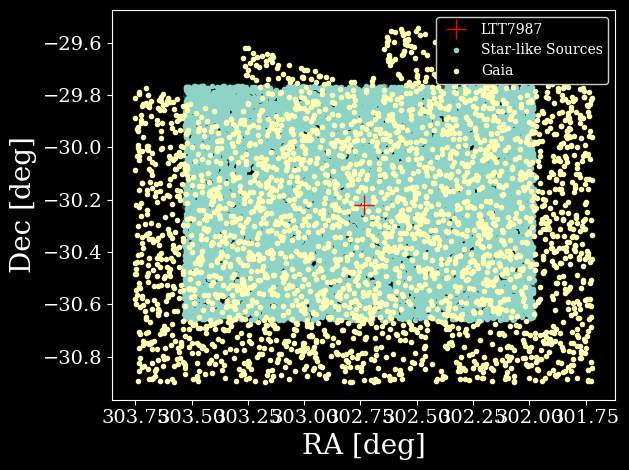

In [110]:
plt.plot(tra, tdec, '+', c='r', ms=15, label=tname, zorder=999)
plt.plot(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], '.', alpha=0.1, c='silver',)
plt.plot(intbl['ALPHA_J2000'][indx_select], intbl['DELTA_J2000'][indx_select], '.', label='Star-like Sources')
plt.plot(gtbl['ra'], gtbl['dec'], '.', label='Gaia')
plt.legend(loc='upper right', framealpha=1.0)

xl, xr = plt.xlim()
plt.xlim([xr, xl])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig(f"{path_save}/{tname}.radec.png")

## Matching with Gaia

In [111]:
indx_match, sep, _ = c_7dt.match_to_catalog_sky(c_gaia)
_mtbl = hstack([intbl, gtbl[indx_match]])
_mtbl = _mtbl[(sep.arcsec<2)]
print(f"Matched {len(_mtbl)} sources")

Matched 1606 sources


In [112]:
_zp_gaia_arr = _mtbl[f'{filte}']-_mtbl['MAG_AUTO']
_zperr_gaia_arr = _mtbl[f'{filte}err']

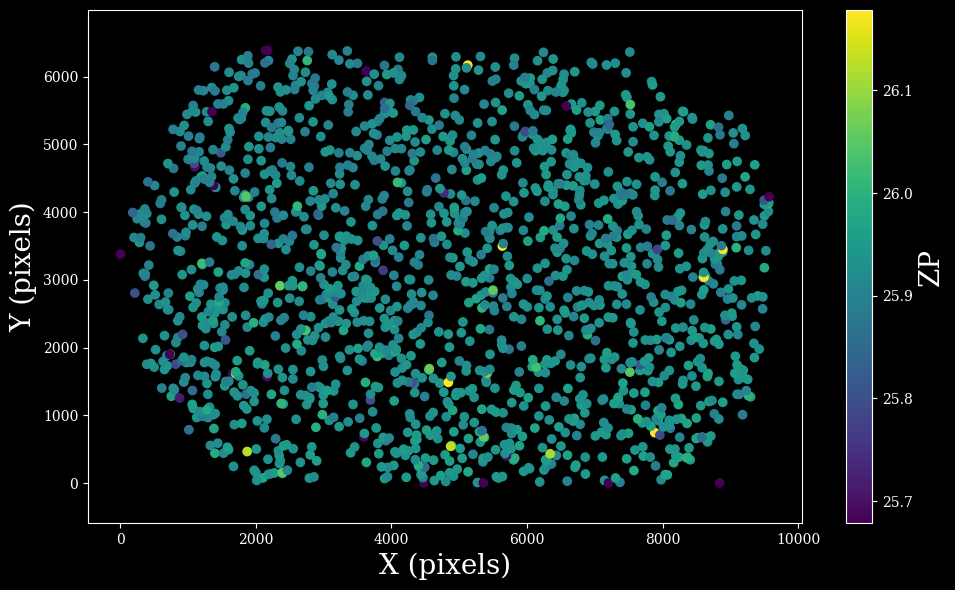

In [113]:
fig = plt.figure(figsize=(10, 6))
plt.axis('equal')

_zp_gaia_tmp = np.median(_zp_gaia_arr)

plt.scatter(_mtbl['X_IMAGE'], _mtbl['Y_IMAGE'], c=_zp_gaia_arr, vmin=_zp_gaia_tmp-0.25, vmax=_zp_gaia_tmp+0.25)
cbar = plt.colorbar()
cbar.set_label('ZP')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.tight_layout()

In [80]:
if filte in ['u', 'g', 'r', 'i', 'z']:
	mtbl = _mtbl[
		(_mtbl['FLAGS']==0) &
		(_mtbl['SNR']>50) &
		(_mtbl[f'cflag_{filte}']=='True')
		]

else:
	mtbl = _mtbl[
		# (sep.arcsec<2)
		# (sep.arcsec<2) &
		# (~_mtbl[f'{filte}'].mask) &
		(_mtbl['FLAGS']==0) &
		#
		# (~_mtbl[f'{filte}'].mask) &
		# (_mtbl[f'{filte}']>14) &
		# (_mtbl[f'{filte}']<18) &
		(_mtbl['SNR']>50)
		]

print(f"Selected {len(mtbl)} sources")

Selected 877 sources


In [81]:
zp_gaia_arr = mtbl[f'{filte}']-mtbl['MAG_AUTO']
zperr_gaia_arr = mtbl[f'{filte}err']

- 3.0 Sigma Clipping
Alive: 863
Exile: 14


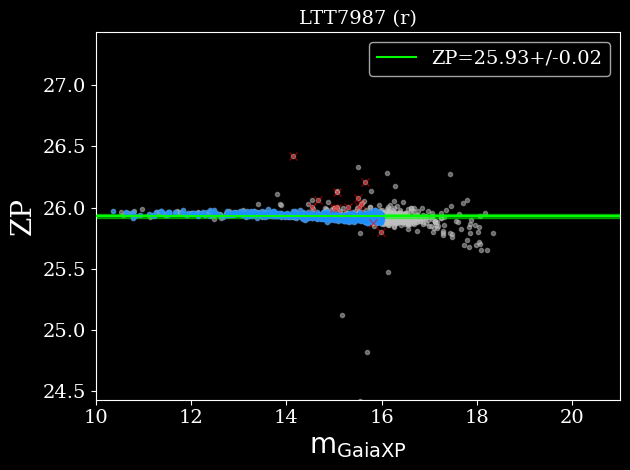

In [82]:
from astropy.stats import sigma_clip

sigma = 3.0
maxiters = None

#	SIGMA CLIPPING
zp_gaia_clip_arr = sigma_clip(
	zp_gaia_arr.copy(),
	sigma=sigma,
	maxiters=maxiters,
	cenfunc=np.median,
	copy=False
	)
indx_alive = np.where( zp_gaia_clip_arr.mask == False )
indx_exile = np.where( zp_gaia_clip_arr.mask == True )

print(f"- {sigma} Sigma Clipping")
print(f"Alive: {len(zp_gaia_arr[indx_alive])}")
print(f"Exile: {len(zp_gaia_arr[indx_exile])}")

zp_gaia, zperr_gaia = np.median(zp_gaia_arr[indx_alive]), np.std(zp_gaia_arr[indx_alive])

plt.title(f"{tname} ({filte})",)

plt.plot(_mtbl[f'{filte}'], _zp_gaia_arr, '.', c='silver', alpha=0.5, zorder=0)
plt.errorbar(mtbl[f'{filte}'], zp_gaia_arr, yerr=zperr_gaia_arr, ls='none', c='grey', alpha=0.5, zorder=0)
plt.plot(mtbl[f'{filte}'][indx_alive], zp_gaia_arr[indx_alive], '.', color='dodgerblue', alpha=0.5)
plt.plot(mtbl[f'{filte}'][indx_exile], zp_gaia_arr[indx_exile], 'xr', alpha=0.5)

plt.axhline(y=zp_gaia, ls='-', color='lime', zorder=999, label=f'ZP={zp_gaia:.2f}+/-{zperr_gaia:.2f}')
plt.axhspan(ymin=zp_gaia-zperr_gaia, ymax=zp_gaia+zperr_gaia, color='lime', zorder=0, alpha=0.5)
plt.xlabel(r"$\rm m_{GaiaXP}$")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("ZP")
plt.xlim([10, 21])
plt.ylim(zp_gaia-1.5, zp_gaia+1.5)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig(f"{path_save}/{tname}.gaia.zpcal.{filte}.png")

## Matching with PS1

In [83]:
indx_match, sep, _ = c_7dt.match_to_catalog_sky(c_ps1)
_mtbl = hstack([intbl, ps1tbl[indx_match]])
print(f"Matched {len(_mtbl)} sources")

Matched 15728 sources


In [84]:
_zp_ps1_arr = _mtbl[f'{filte}mag']-_mtbl['MAG_AUTO']
_zperr_ps1_arr = np.sqrt( (_mtbl[f'e_{filte}mag']**2) + (_mtbl['MAGERR_AUTO']**2) )

In [85]:
mtbl = _mtbl[
	(sep.arcsec<2) &
	(~_mtbl[f'{filte}mag'].mask) &
	(_mtbl[f'{filte}mag']>14) &
	(_mtbl[f'{filte}mag']<18) &
	(_mtbl['SNR']>50) &
	(_mtbl['CLASS_STAR']>0.9) &
	(~_mtbl[f'e_{filte}mag'].mask)
	]
print(f"Selected {len(mtbl)} sources")

Selected 1385 sources


In [86]:
zp_ps1_arr = mtbl[f'{filte}mag']-mtbl['MAG_AUTO']
zperr_ps1_arr = np.sqrt( (mtbl[f'e_{filte}mag']**2) + (mtbl['MAGERR_AUTO']**2) )

- 3.0 Sigma Clipping
Alive: 1344
Exile: 41
zp = 25.902+/-0.031


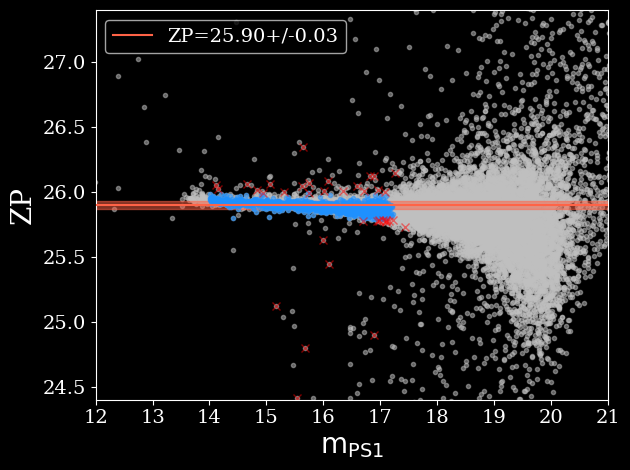

In [95]:
from astropy.stats import sigma_clip

sigma = 3.0
maxiters = None

#	SIGMA CLIPPING
zp_ps1_clip_arr = sigma_clip(
	zp_ps1_arr.copy(),
	sigma=sigma,
	maxiters=maxiters,
	cenfunc=np.median,
	copy=False
	)
indx_alive = np.where( zp_ps1_clip_arr.mask == False )
indx_exile = np.where( zp_ps1_clip_arr.mask == True )

print(f"- {sigma} Sigma Clipping")
print(f"Alive: {len(zp_ps1_arr[indx_alive])}")
print(f"Exile: {len(zp_ps1_arr[indx_exile])}")

zp_ps1, zperr_ps1 = calc_weighted_median_zp(zp_ps1_arr[indx_alive], zperr_ps1_arr[indx_alive])

plt.plot(_mtbl[f'{filte}mag'], _zp_ps1_arr, '.', c='silver', alpha=0.5, zorder=0)
# plt.plot(mtbl[f'{filte}mag'], zp_ps1_arr, '.', alpha=0.5)
plt.plot(mtbl[f'{filte}mag'][indx_alive], zp_ps1_arr[indx_alive], '.', color='dodgerblue', alpha=0.5)
plt.plot(mtbl[f'{filte}mag'][indx_exile], zp_ps1_arr[indx_exile], 'xr', alpha=0.5)

plt.axhline(y=zp_ps1, ls='-', color='tomato', zorder=999, label=f'ZP={zp_ps1:.2f}+/-{zperr_ps1:.2f}')
plt.axhspan(ymin=zp_ps1-zperr_ps1, ymax=zp_ps1+zperr_ps1, color='tomato', zorder=0, alpha=0.5)
plt.xlabel(r"$\rm m_{PS1}$")
plt.ylabel("ZP")
plt.xlim([12, 21])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(zp_ps1-1.5, zp_ps1+1.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"{path_save}/{tname}.ps1.zpcal.{filte}.png")

## Xshooter or CALSPEC

In [88]:
xstbl = Table.read(f'../output/{tname}/7dt.all.phot.csv')

In [89]:
if 'm' in filte:
	refmag = xstbl['magapp'][xstbl['filter']==f"{filte}0"].item()
else:
	refmag = xstbl['magapp'][xstbl['filter']==filte].item()
print(f"ref.mag in {filte}: {refmag}")

ref.mag in r: 12.414


In [90]:
indx, sep, _ = c_target.match_to_catalog_sky(c_7dt)

mag = intbl['MAG_AUTO'][indx]
magerr = intbl['MAGERR_AUTO'][indx]
print(f"inst.mag={mag:.3f}+/-{magerr:.3f}")
print('sep=', sep.arcsec)

inst.mag=-13.567+/-0.000
sep= [0.90343783]


In [91]:
zp = refmag - mag
print(f"ZP={zp:.3f}")

ZP=25.981


# Result

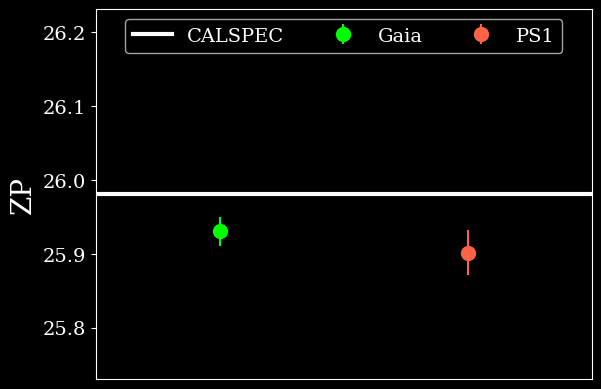

In [92]:
plt.axhline(y=zp, label='CALSPEC', lw=3, zorder=0)
plt.errorbar(0, zp_gaia, yerr=zperr_gaia, ms=10, color='lime', fmt='o', label='Gaia')
plt.errorbar(1, zp_ps1, yerr=zperr_ps1, ms=10, color='tomato', fmt='o', label='PS1')
plt.ylim(zp-0.25, zp+0.25)
plt.xlim(-0.5, 1.5)
xticks = plt.xticks([])
plt.yticks(fontsize=14)

plt.legend(loc='upper center', ncol=3, fontsize=14)
plt.ylabel('ZP')
plt.savefig(f'../output/{tname}.zpcomp.png')

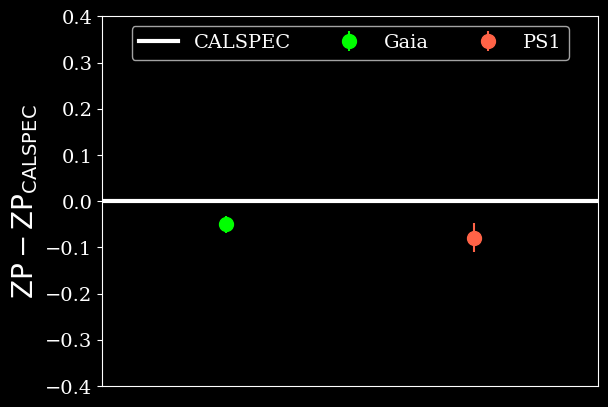

In [93]:
plt.axhline(y=zp-zp, label='CALSPEC', lw=3, zorder=0)
plt.errorbar(0, zp_gaia-zp, yerr=zperr_gaia, ms=10, color='lime', fmt='o', label='Gaia')
plt.errorbar(1, zp_ps1-zp, yerr=zperr_ps1, ms=10, color='tomato', fmt='o', label='PS1')
# plt.ylim(zp-0.25, zp+0.25)
plt.ylim(-0.4, +0.4)
plt.xlim(-0.5, 1.5)
xticks = plt.xticks([])
plt.yticks(fontsize=14)

plt.legend(loc='upper center', ncol=3, fontsize=14)
plt.ylabel(r'$\rm ZP-ZP_{CALSPEC}$')
plt.savefig(f'../output/{tname}.zpres.png')